In [3]:
import reservoirpy as rpy
import numpy as np

# 1. Set some global parameters
rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everything reproducible!

In [4]:
# パラメータ設定
n_timesteps = 5000
units = 2000
spectral_radii = np.linspace(0.1, 1.5, 10)

In [5]:
# 2. Create the reservoir and readout
from reservoirpy.nodes import Reservoir, Ridge

def create_model(spectral_radius):
    reservoir = Reservoir(units=units, sr=spectral_radius)
    readout = Ridge(ridge=1e-7)
    return reservoir >> readout

In [6]:
# ホワイトノイズ信号生成
np.random.seed(42)
input_signal = np.random.randn(n_timesteps).reshape(-1, 1)

In [7]:
from sklearn.metrics import r2_score

def compute_memory_capacity(esn, input_signal, max_delay=10):
    mc = []
    for d in range(1, max_delay + 1):
        # 遅延 d ごとにリザーバーをリセットしてフィット
        esn.reset()
        
        # 遅延 d だけシフトした入力に対して出力層を学習
        esn.fit(input_signal[:-d], input_signal[d:])
        
        # 学習済み出力重みで予測を行う
        pred = esn.run(input_signal[:-d])
        
        # 決定係数（R^2スコア）を計算してメモリー容量に加算
        r2 = r2_score(input_signal[d:], pred)
        mc.append(r2)
    
    return np.array(mc)

In [8]:
mc_dict = {}

for sr in spectral_radii:
    esn = create_model(sr)
    mc = compute_memory_capacity(esn, input_signal)
    print(f"Spectral radius: {sr:.2f}, MC: {mc.mean():.2f}")
    mc_dict[sr] = mc

Spectral radius: 0.10, MC: 0.03
Spectral radius: 0.26, MC: 0.12
Spectral radius: 0.41, MC: 0.27
Spectral radius: 0.57, MC: 0.39
Spectral radius: 0.72, MC: 0.40
Spectral radius: 0.88, MC: 0.40
Spectral radius: 1.03, MC: 0.40
Spectral radius: 1.19, MC: 0.39
Spectral radius: 1.34, MC: 0.40
Spectral radius: 1.50, MC: 0.39


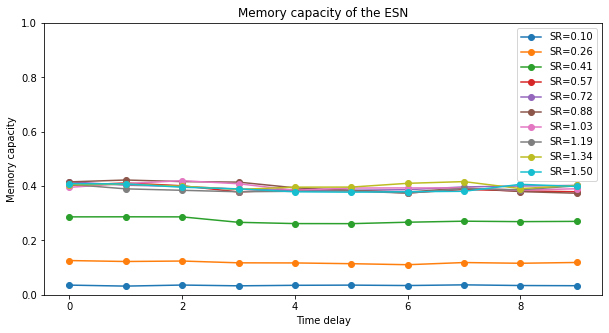

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for sr, mc in mc_dict.items():
    plt.plot(mc, marker='o', label=f"SR={sr:.2f}")
plt.xlabel('Time delay')
plt.ylabel('Memory capacity')
plt.title('Memory capacity of the ESN')
plt.legend()
plt.ylim(0, 1)
plt.show()